In [ ]:
!pip install nilearn

In [4]:
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.decomposition import PCA, FastICA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, r2_score
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.linalg import LinAlgWarning
warnings.filterwarnings('ignore', category=LinAlgWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# **Dataset A**

In [5]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=200) # this needs to be modified for  some tasks
print('%i regions found in this atlas' % (len(np.unique(nib.load(yeo.maps).get_fdata().ravel()))  - 1))
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True,   memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int) # gives 1 for females  and 0 for males

200 regions found in this atlas


### **Question 1**

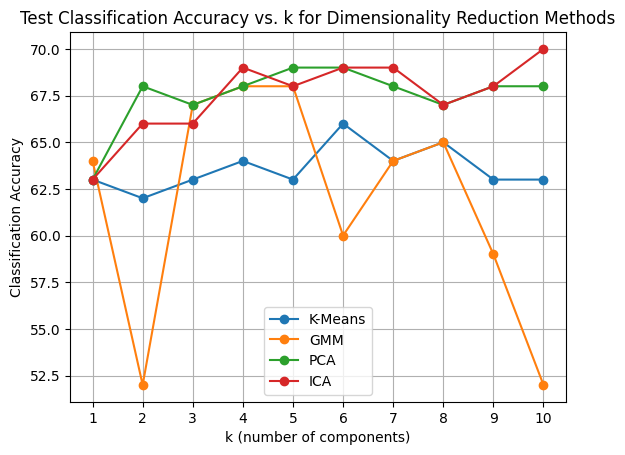

In [43]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100) # Load dataset and atlas
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=100)  # Modified for 100 ROIs
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars['mf'] == 'F', dtype=int)

log_model_q1 = LogisticRegression(penalty='l2', C=1.0) # Create log model
k_values = np.arange(1, 11) # Get k values from 1 to 10
KF_q1 = KFold(n_splits=5) # Set up 5-fold cross-validation
acc_kmeans_q1, acc_gmm_q1, acc_pca_q1, acc_ica_q1 = [], [], [], [] # Store classification accuracies

for k in k_values: # Iterate through each k value
    for method in ['kmeans', 'gmm', 'pca', 'ica']: # Iterate through each method
        kvals_method = [] # List to store accuracies for each fold
        if method == 'kmeans': # If method is kmeans, create kmeans object & fit data
            X_kmeans = KMeans(n_clusters=k, random_state=0).fit_transform(input_variables)
            current_method, acc_method = X_kmeans, acc_kmeans_q1 # Set current method and accuracy
        elif method == 'gmm': # If method is gmm, create gmm object & fit data
            X_gmm = GaussianMixture(n_components=k, random_state=0).fit_predict(input_variables).reshape(-1, 1)
            current_method, acc_method = X_gmm, acc_gmm_q1
        elif method == 'pca': # If method is pca, create pca object & fit data
            X_pca = PCA(n_components=k, random_state=0).fit_transform(input_variables)
            current_method, acc_method = X_pca, acc_pca_q1
        elif method == 'ica': # If method is ica, create ica object & fit data
            X_ica = FastICA(n_components=k, random_state=0).fit_transform(input_variables)
            current_method, acc_method = X_ica, acc_ica_q1

        for train_index, test_index in KF_q1.split(input_variables): # Iterate through each fold
            X_train_method, X_test_method = current_method[train_index], current_method[test_index] # Split training data
            y_train, y_test = output_variable[train_index], output_variable[test_index] # Split testing data

            log_model_q1.fit(X_train_method, y_train) # Fit log model
            y_pred = log_model_q1.predict(X_test_method) # Predict y values
            kvals_method.append(accuracy_score(y_test, y_pred)*100) # Calculate accuracy & add to list

        acc_method.append(np.mean(kvals_method)) # Calculate mean accuracy for each k value

# Plot the results
plt.plot(k_values, acc_kmeans_q1, label='K-Means', marker='o') 
plt.plot(k_values, acc_gmm_q1, label='GMM', marker='o')
plt.plot(k_values, acc_pca_q1, label='PCA', marker='o')
plt.plot(k_values, acc_ica_q1, label='ICA', marker='o')
plt.xlabel('k (number of components)')
plt.ylabel('Classification Accuracy')
plt.xticks(k_values)
plt.title('Test Classification Accuracy vs. k for Dimensionality Reduction Methods')
plt.legend()
plt.grid(True)
plt.show()

### **Question 2**

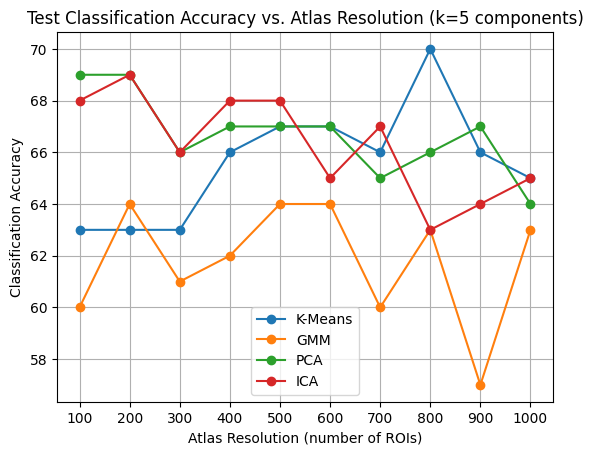

In [44]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100) # Load dataset and atlas
regions = list(range(100,1100,100)) # Atlas resolutions
log_model_q2 = LogisticRegression(penalty='l2', C=1.0) # Create log model
KF_q2 = KFold(n_splits=5) # Set up 5-fold cross-validation
acc_kmeans_q2, acc_gmm_q2, acc_pca_q2, acc_ica_q2 = [], [], [], [] # Store classification accuracies

for region in regions: # Iterate through each region
    yeo = datasets.fetch_atlas_schaefer_2018(n_rois=region)
    masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = np.array(brain_data.ext_vars['mf'] == 'F', dtype=int)

    for method in ['kmeans', 'gmm', 'pca', 'ica']: # Iterate through each method
        kvals_method = [] # List to store accuracies for each fold

        if method == 'kmeans': # If method is kmeans, create kmeans object & fit data
            X_kmeans = KMeans(n_clusters=5, random_state=42).fit_transform(input_variables)
            current_method, acc_method = X_kmeans, acc_kmeans_q2
        elif method == 'gmm': # If method is gmm, create gmm object & fit data
            X_gmm = GaussianMixture(n_components=5, random_state=42).fit_predict(input_variables).reshape(-1, 1)
            current_method, acc_method = X_gmm, acc_gmm_q2
        elif method == 'pca': # If method is pca, create pca object & fit data
            X_pca = PCA(n_components=5, random_state=42).fit_transform(input_variables)
            current_method, acc_method = X_pca, acc_pca_q2
        elif method == 'ica': # If method is ica, create ica object & fit data
            X_ica = FastICA(n_components=5, random_state=42).fit_transform(input_variables)
            current_method, acc_method = X_ica, acc_ica_q2

        for train_index, test_index in KF_q2.split(input_variables): # Iterate through each fold
            X_train_method, X_test_method = current_method[train_index], current_method[test_index] # Split training data
            y_train, y_test = output_variable[train_index], output_variable[test_index] # Split testing data

            log_model_q2.fit(X_train_method, y_train) # Fit log model
            y_pred = log_model_q2.predict(X_test_method) # Predict y values
            kvals_method.append(accuracy_score(y_test, y_pred)*100) # Calculate accuracy & add to list

        acc_method.append(np.mean(kvals_method)) # Calculate mean accuracy for each region

# Plot the results
plt.plot(regions, acc_kmeans_q2, label='K-Means', marker='o')
plt.plot(regions, acc_gmm_q2, label='GMM', marker='o')
plt.plot(regions, acc_pca_q2, label='PCA', marker='o')
plt.plot(regions, acc_ica_q2, label='ICA', marker='o')
plt.xlabel('Atlas Resolution (number of ROIs)')
plt.ylabel('Classification Accuracy')
plt.xticks(regions)
plt.title('Test Classification Accuracy vs. Atlas Resolution (k=5 components)')
plt.legend()
plt.grid(True)
plt.show()

### **Question 3**

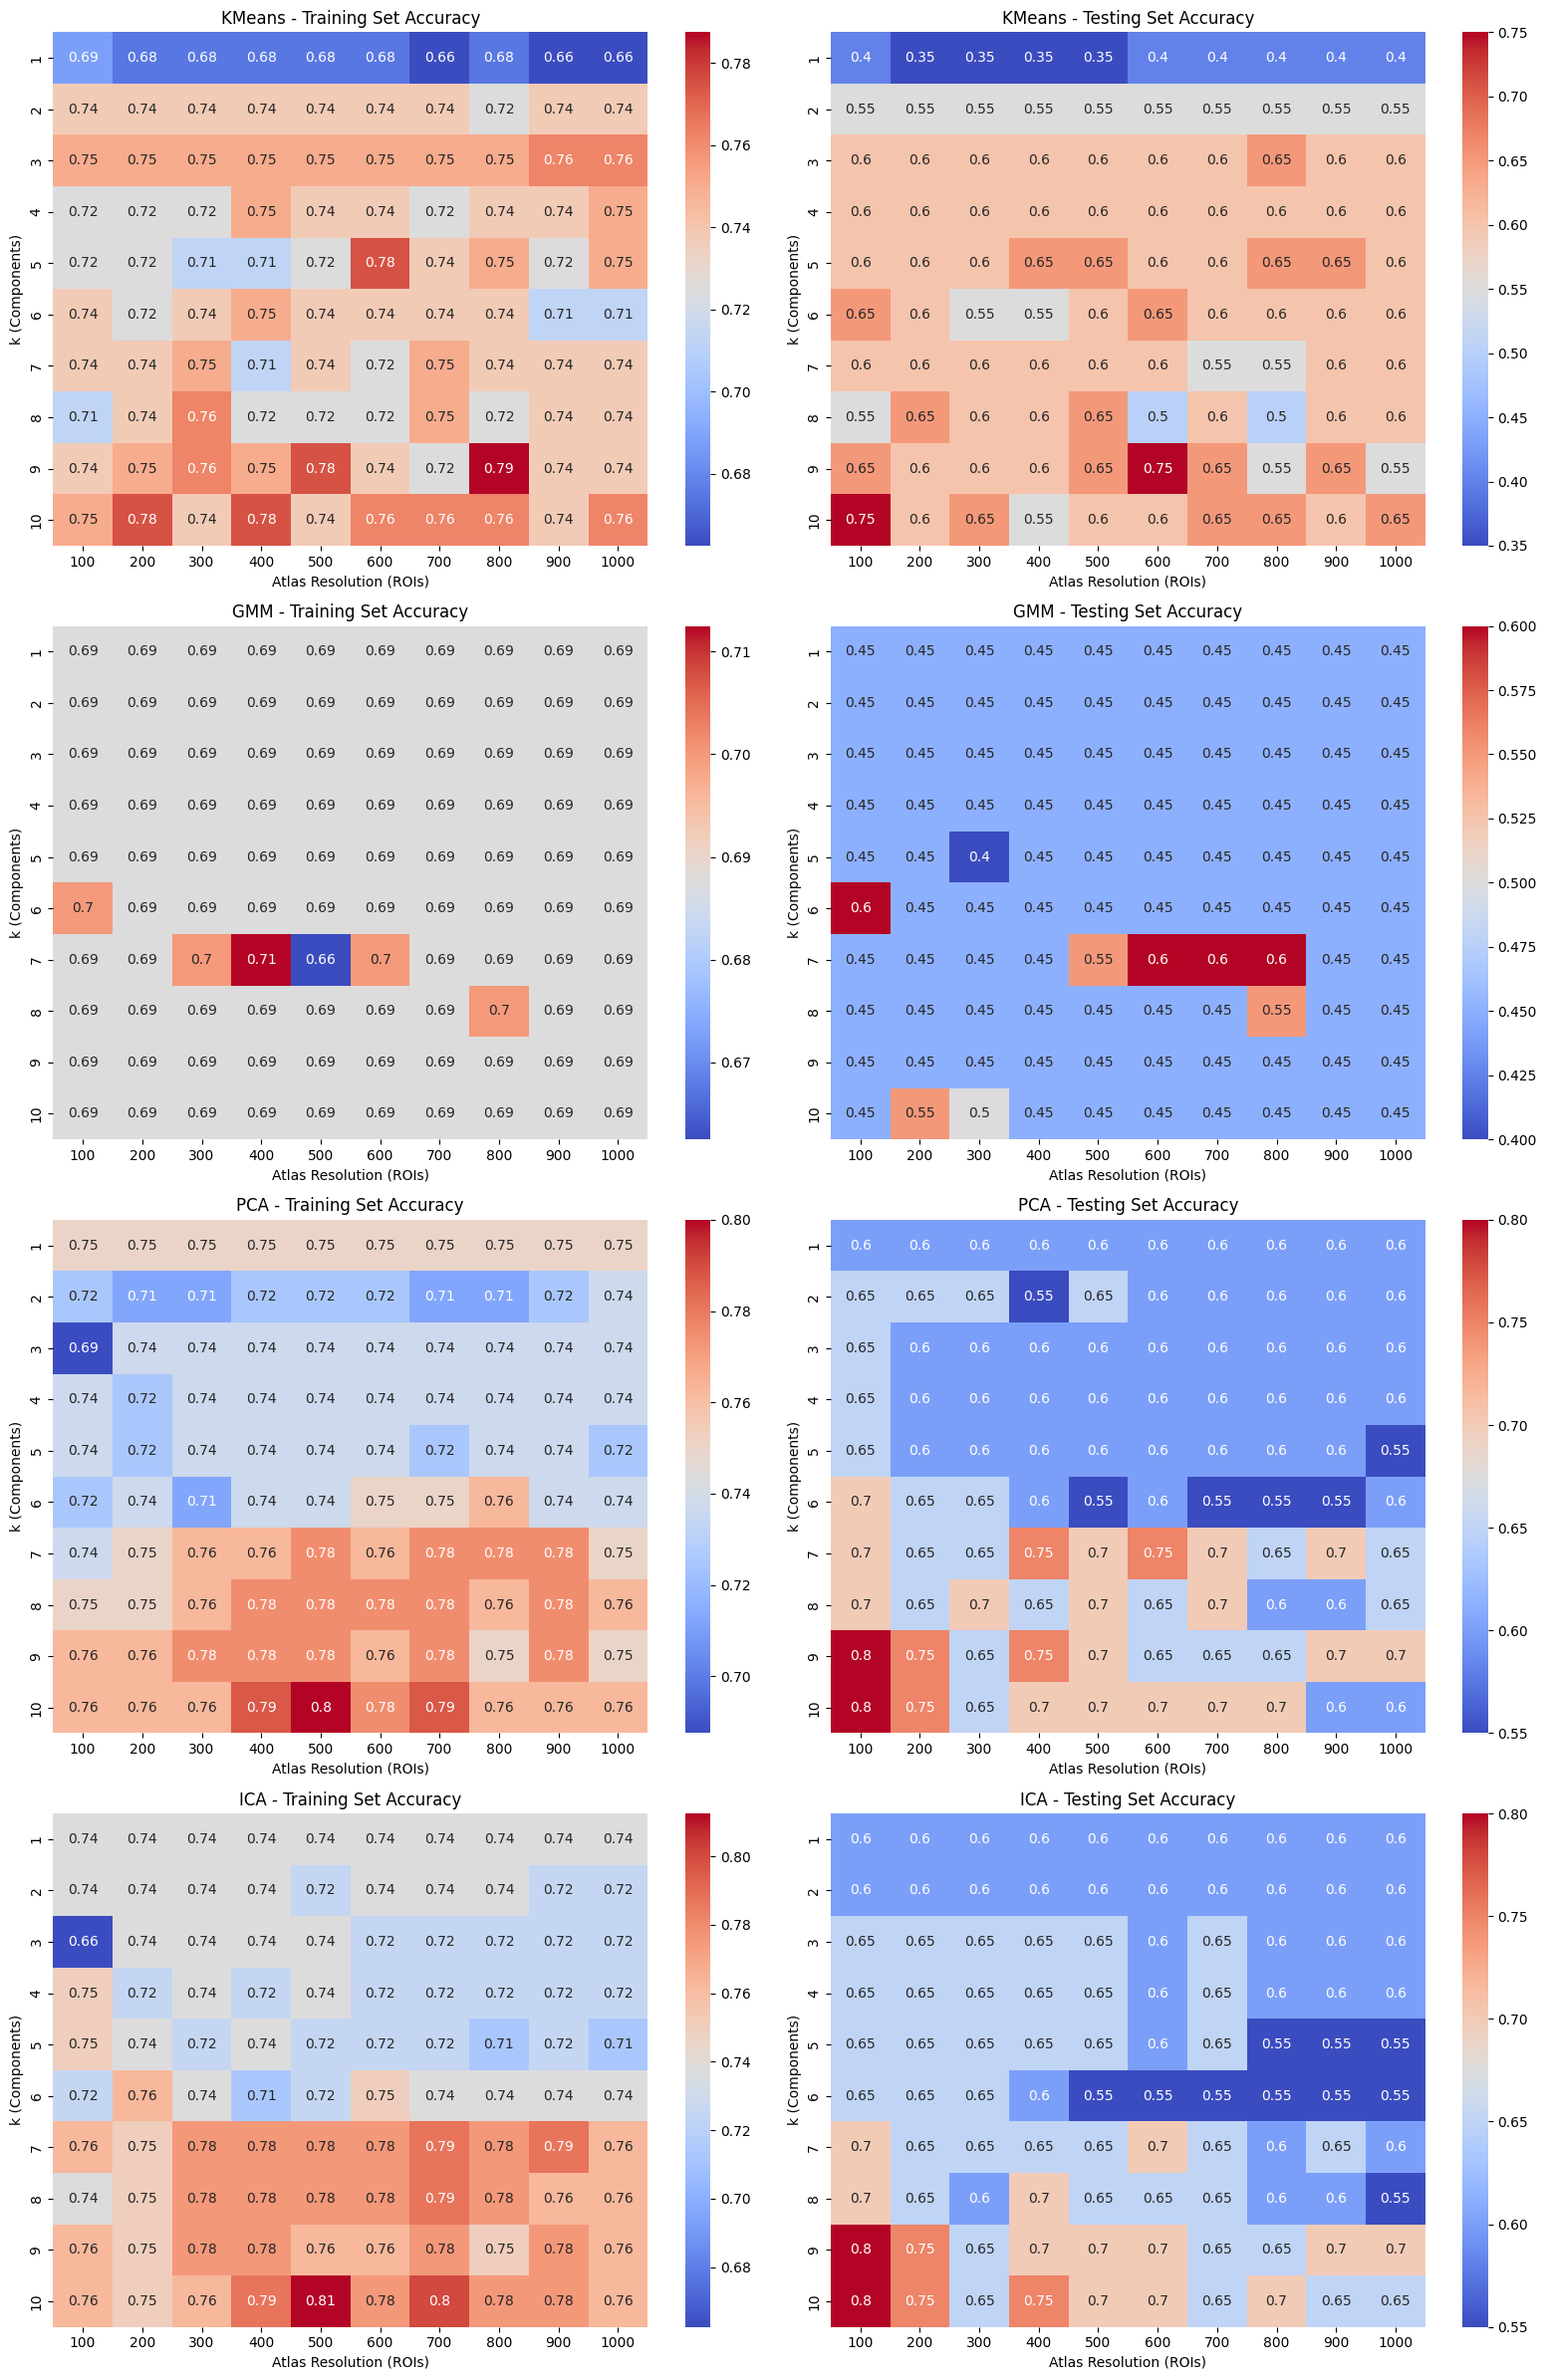

In [76]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100) # Load dataset
regions = list(range(100,1100,100)) # List of atlas resolutions
k_values = np.arange(1, 11) # k values from 1 to 10
logmodel_q3 = LogisticRegression(penalty='l2', C=1.0) # Create log model
KF_q3 = KFold(n_splits=5) # Set up KFold cross-validation

methods = ['KMeans', 'GMM', 'PCA', 'ICA'] # List of methods
results_train = {method: np.zeros((len(k_values), len(regions))) for method in methods} # Store training accuracies
results_test = {method: np.zeros((len(k_values), len(regions))) for method in methods} # Store testing accuracies
regions=list(range(100,1100,100)) # List of atlas resolutions

for i, region in enumerate(regions): # Iterate through each region
    yeo = datasets.fetch_atlas_schaefer_2018(n_rois=region)
    masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int) # gives 1 for females  and 0 for males

    for j, k in enumerate(k_values): # Iterate through each k value
        # Set up & fit models on input variables
        X_kmeans = KMeans(n_clusters=k, random_state=42).fit_transform(input_variables)
        X_gmm = GaussianMixture(n_components=k, random_state=42).fit_predict(input_variables).reshape(-1, 1)
        X_pca = PCA(n_components=k, random_state=42).fit_transform(input_variables)
        X_ica = FastICA(n_components=k, random_state=42).fit_transform(input_variables)

        for name, method in zip(methods, [X_kmeans, X_gmm, X_pca, X_ica]): # Iterate through each method
            for train_index, test_index in KF_q3.split(input_variables): # Split data into training and testing sets
                X_train, X_test = method[train_index], method[test_index] # Split training data
                y_train, y_test = output_variable[train_index], output_variable[test_index] # Split testing data

                logmodel_q3.fit(X_train, y_train) # Fit log model
                y_pred_train = logmodel_q3.predict(X_train) # Predict training data
                y_pred_test = logmodel_q3.predict(X_test) # Predict testing data

                results_train[name][j, i] = accuracy_score(y_train, y_pred_train) # Store training accuracy
                results_test[name][j, i] = accuracy_score(y_test, y_pred_test) # Store testing accuracy
        
# Plot the heatmaps
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
for idx, method in enumerate(methods): # Iterate through each method
    # Plot heatmap
    sns.heatmap(results_train[method], ax=axes[idx, 0], cmap="coolwarm", annot=True, xticklabels=regions, yticklabels=k_values)
    axes[idx, 0].set_title(f'{method} - Training Set Accuracy') # Add title
    axes[idx, 0].set_xlabel('Atlas Resolution (ROIs)') # Add x-axis label
    axes[idx, 0].set_ylabel('k (Components)') # Add y-axis label
    # Plot second heatmap
    sns.heatmap(results_test[method], ax=axes[idx, 1], cmap="coolwarm", annot=True, xticklabels=regions, yticklabels=k_values)
    axes[idx, 1].set_title(f'{method} - Testing Set Accuracy') # Add title
    axes[idx, 1].set_xlabel('Atlas Resolution (ROIs)') # Add x-axis label
    axes[idx, 1].set_ylabel('k (Components)') # Add y-axis label
plt.tight_layout()
plt.show()

### **Question 4**

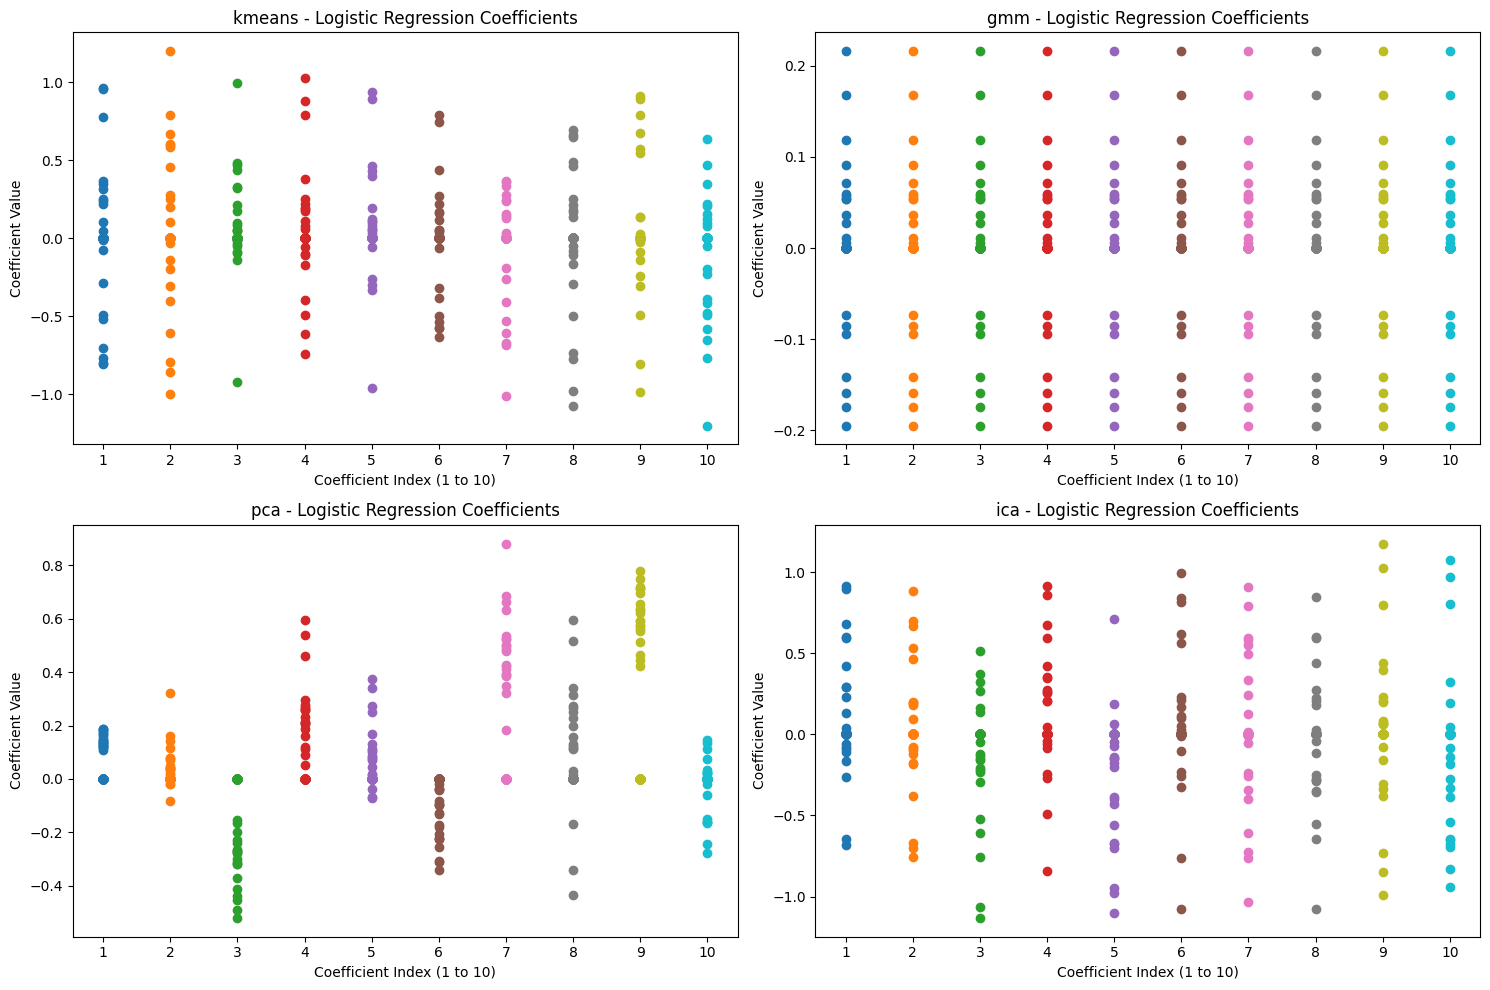

In [78]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100) # Load dataset and atlas
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=100)  # Modified for 100 ROIs
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars['mf'] == 'F', dtype=int)

logmodel_q4 = LogisticRegression(penalty='l2', C=1.0) # Create log model
k_values = np.arange(1, 11) # Get k values from 1 to 10

# Coefficient matrices for each method (20 KFold)*(5 fold)=100 estimates
kmeans_coefs, gmm_coefs, pca_coefs, ica_coefs = np.zeros((100, 10)), np.zeros((100, 10)), np.zeros((100, 10)), np.zeros((100, 10))
coef_dict = {'kmeans': kmeans_coefs, 'gmm': gmm_coefs, 'pca': pca_coefs, 'ica': ica_coefs}

for i in range(20): # Repeat process 20 times
    random_state_kfold = np.random.randint(0,1000)  # New random state for each iteration
    KF_q4 = KFold(n_splits=5, shuffle=True, random_state=random_state_kfold) # Set up 5-fold cross-validation

    for train_index, test_index in KF_q4.split(input_variables): # Split data into training and testing sets
        random_state_method = np.random.randint(0,1000)  # New random state for each method
        # Set up the 4 methods and fit on input variables
        X_kmeans = KMeans(n_clusters=10, random_state=random_state_method).fit_transform(input_variables)
        X_gmm = GaussianMixture(n_components=10, random_state=random_state_method).fit_predict(input_variables).reshape(-1, 1)
        X_pca = PCA(n_components=10, random_state=random_state_method).fit_transform(input_variables)
        X_ica = FastICA(n_components=10, random_state=random_state_method).fit_transform(input_variables)
        
        names_dict = {'kmeans': X_kmeans, 'gmm': X_gmm, 'pca': X_pca, 'ica': X_ica} # Store method names
        
        for name, method in names_dict.items(): # Iterate through each method
            X_train, X_test = method[train_index], method[test_index] # Split train data
            y_train, y_test = output_variable[train_index], output_variable[test_index] # Split test data

            logmodel_q4.fit(X_train, y_train) # Fit log model
            coef_dict[name][i, :] = logmodel_q4.coef_.flatten() # Store coefficients

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for idx, method in enumerate(['kmeans', 'gmm', 'pca', 'ica']): # Iterate over each method
    coeffs = coef_dict[method]  # Coefficients matrix for current method (100x10)
    for i in range(10):  # For each of 10 coefs, plot 100 estimates
        axes[idx].scatter(np.full(100, i + 1), coeffs[:, i], label=f'Coeff {i+1}' if i == 0 else "")
    axes[idx].set_title(f'{method} - Logistic Regression Coefficients') # Add title
    axes[idx].set_xlabel('Coefficient Index (1 to 10)') # Add x-axis label
    axes[idx].set_ylabel('Coefficient Value') # Add y-axis label
    axes[idx].set_xticks(np.arange(1, 11))  # Set x-axis to show 1 to 10 for the 10 coefficients
plt.tight_layout()
plt.show()

### **Question 5**

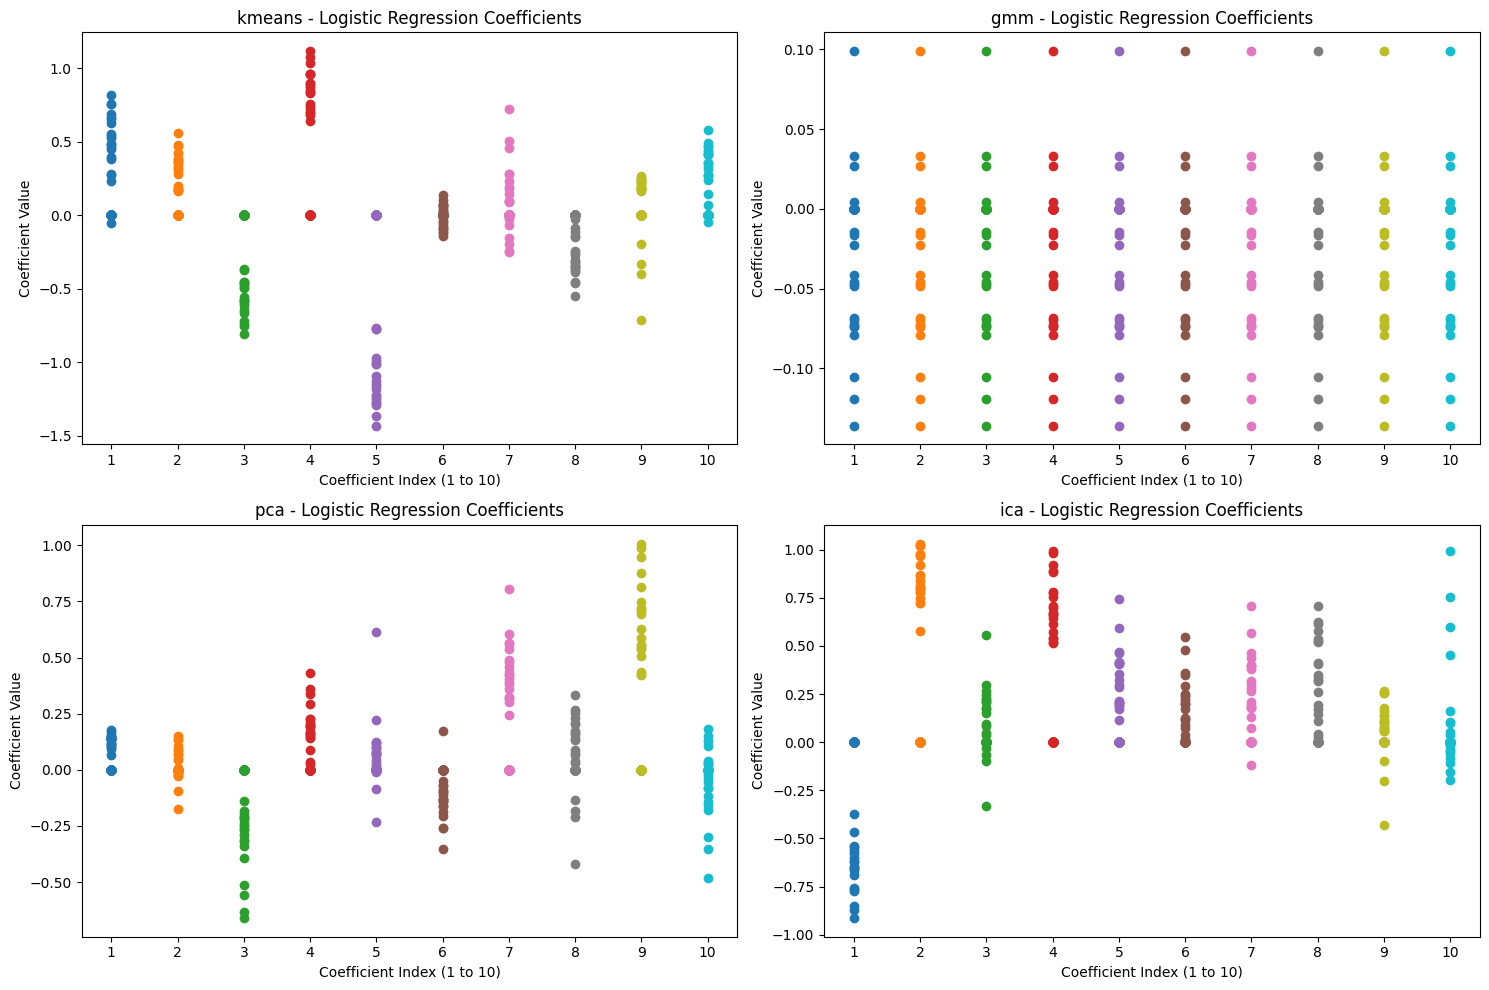

In [79]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100) # Load dataset and atlas
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=100)  # Modified for 100 ROIs
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars['mf'] == 'F', dtype=int)

logmodel_q5 = LogisticRegression(penalty='l2', C=1.0) # Create log model
k_values = np.arange(1, 11) # Get k values from 1 to 10

# Coefficient matrices for each method (20 KFold)*(5 fold)=100 estimates
kmeans_coefs, gmm_coefs, pca_coefs, ica_coefs = np.zeros((100, 10)), np.zeros((100, 10)), np.zeros((100, 10)), np.zeros((100, 10))
coef_dict = {'kmeans': kmeans_coefs, 'gmm': gmm_coefs, 'pca': pca_coefs, 'ica': ica_coefs}

for i in range(20): # Repeat process 20 times
    random_state_kfold = np.random.randint(0,1000)  # New random state for each iteration
    KF_q5 = KFold(n_splits=5, shuffle=True, random_state=random_state_kfold) # Set up KFold cross-validation
    # Set up each method & fit on input variables
    X_kmeans = KMeans(n_clusters=10, random_state=42).fit_transform(input_variables)
    X_gmm = GaussianMixture(n_components=10, random_state=42).fit_predict(input_variables).reshape(-1, 1)
    X_pca = PCA(n_components=10, random_state=42).fit_transform(input_variables)
    X_ica = FastICA(n_components=10, random_state=42).fit_transform(input_variables)
    
    for train_index, test_index in KF_q5.split(input_variables): # Split data into training and testing sets
        names_dict = {'kmeans': X_kmeans, 'gmm': X_gmm, 'pca': X_pca, 'ica': X_ica} # Store method names
        
        for name, method in names_dict.items(): # Iterate through each method
            X_train, X_test = method[train_index], method[test_index] # Split training data
            y_train, y_test = output_variable[train_index], output_variable[test_index] # Split testing data
            
            logmodel_q5.fit(X_train, y_train) # Fit log model
            coef_dict[name][i,:] = logmodel_q5.coef_.flatten() # Store coefficients

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for idx, method in enumerate(['kmeans', 'gmm', 'pca', 'ica']): # Iterate over each method
    coeffs = coef_dict[method]  # Coefficients matrix for current method (100x10)
    for i in range(10):  # For each of 10 coefs, plot 100 estimates
        axes[idx].scatter(np.full(100, i + 1), coeffs[:, i], label=f'Coeff {i+1}' if i == 0 else "")
    axes[idx].set_title(f'{method} - Logistic Regression Coefficients') # Add title
    axes[idx].set_xlabel('Coefficient Index (1 to 10)') # Add x-axis label
    axes[idx].set_ylabel('Coefficient Value') # Add y-axis label
    axes[idx].set_xticks(np.arange(1, 11))  # Set x-axis to show 1 to 10 for the 10 coefficients
plt.tight_layout()
plt.show()

# **Dataset B**

In [15]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 42) # this needs to be modified for some tasks print('%i regions found in this atlas' % (len(np.unique(atlas_nii.get_data().ravel())) - 1))
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] #  gives subject age on standard units after z-scoring

### **Question 6**

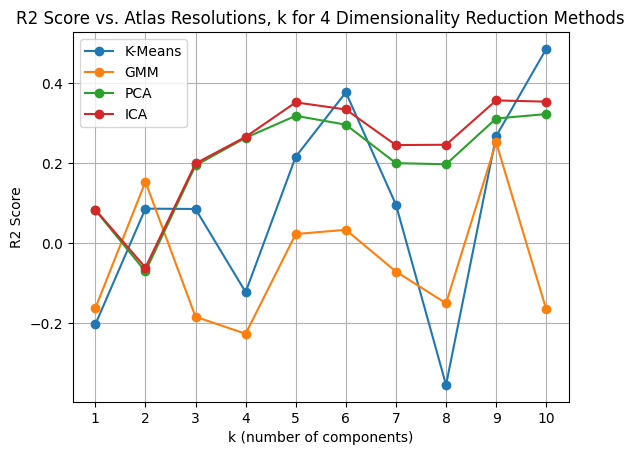

In [62]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 42) # this needs to be modified for some tasks print('%i regions found in this atlas' % (len(np.unique(atlas_nii.get_data().ravel())) - 1))
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] #  gives subject age on standard units after z-scoring

ridge_q6 = Ridge() # Create Ridge model
k_values = np.arange(1, 11) # Get k values from 1 to 10
KF_q6 = KFold(n_splits=5) # Set up 5-fold cross-validation
r2_kmeans_q6, r2_gmm_q6, r2_pca_q6, r2_ica_q6 = [], [], [], [] # Store classification accuracies

for k in k_values: # Iterate through each k value
    for method in ['kmeans', 'gmm', 'pca', 'ica']: # Iterate through each method
        kvals_method = [] # Store R2 scores for each k value
        if method == 'kmeans': # If method is KMeans, create KMeans model and fit on data
            X_kmeans = KMeans(n_clusters=k, random_state=42).fit_transform(input_variables)
            current_method, r2_method = X_kmeans, r2_kmeans_q6 # Store current method and R2 scores
        elif method == 'gmm': # If method is GMM, create GMM model and fit on data
            X_gmm = GaussianMixture(n_components=k, random_state=42).fit_predict(input_variables).reshape(-1, 1)
            current_method, r2_method = X_gmm, r2_gmm_q6 # Store current method and R2 scores
        elif method == 'pca': # If method is PCA, create PCA model and fit on data
            X_pca = PCA(n_components=k, random_state=42).fit_transform(input_variables)
            current_method, r2_method = X_pca, r2_pca_q6 # Store current method and R2 scores
        elif method == 'ica': # If method is ICA, create ICA model and fit on data
            X_ica = FastICA(n_components=k, random_state=42).fit_transform(input_variables)
            current_method, r2_method = X_ica, r2_ica_q6 # Store current method and R2 scores

        for train_index, test_index in KF_q6.split(input_variables): # Split data into training and testing sets
            X_train_method, X_test_method = current_method[train_index], current_method[test_index] # Split training data
            y_train, y_test = output_variable[train_index], output_variable[test_index] # Split testing data

            ridge_q6.fit(X_train_method, y_train) # Fit Ridge model
            y_pred = ridge_q6.predict(X_test_method) # Predict testing data
            kvals_method.append(r2_score(y_test, y_pred)) # Store R2 score

        r2_method.append(np.mean(kvals_method)) # Store average R2 score for each k value

# Plot the results
plt.plot(k_values, r2_kmeans_q6, label='K-Means', marker='o') 
plt.plot(k_values, r2_gmm_q6, label='GMM', marker='o')
plt.plot(k_values, r2_pca_q6, label='PCA', marker='o')
plt.plot(k_values, r2_ica_q6, label='ICA', marker='o')
plt.xlabel('k (number of components)')
plt.ylabel('R2 Score')
plt.xticks(k_values)
plt.title('R2 Score vs. Atlas Resolutions, k for 4 Dimensionality Reduction Methods')
plt.legend()
plt.grid(True)
plt.show()

### **Question 7**

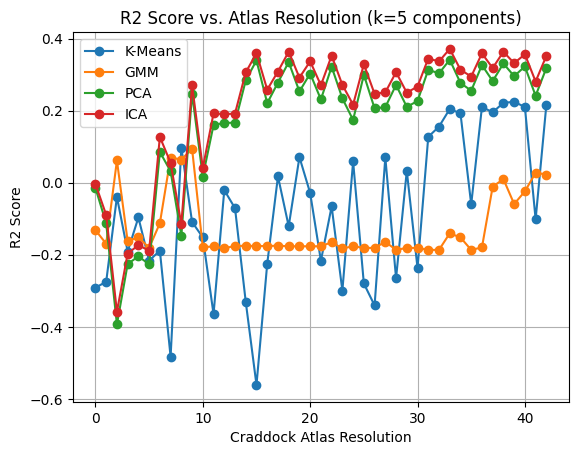

In [95]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100) # Load dataset
crad = datasets.fetch_atlas_craddock_2012()
atlas_indices=list(range(43)) # List of atlas resolutions
ridge_q7 = Ridge() # Create Ridge model
KF_q7 = KFold(n_splits=5) # Set up 5-fold cross-validation
r2_kmeans_q7, r2_gmm_q7, r2_pca_q7, r2_ica_q7 = [], [], [], [] # Store R2 scores

for i in atlas_indices: # Iterate through each region
    atlas_nii = index_img(crad['scorr_mean'], i) # this needs to be modified for some tasks print('%i regions found in this atlas' % (len(np.unique(atlas_nii.get_data().ravel())) - 1))
    masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] #  gives subject age on standard units after z-scoring

    for method in ['kmeans', 'gmm', 'pca', 'ica']: # Iterate through each method
        kvals_method = [] # Store R2 scores for each fold
        if method == 'kmeans': # If method is KMeans, create KMeans model and fit on data
            X_kmeans = KMeans(n_clusters=5, random_state=42).fit_transform(input_variables)
            current_method, r2_method = X_kmeans, r2_kmeans_q7
        elif method == 'gmm': # If method is GMM, create GMM model and fit on data
            X_gmm = GaussianMixture(n_components=5, random_state=42).fit_predict(input_variables).reshape(-1, 1)
            current_method, r2_method = X_gmm, r2_gmm_q7
        elif method == 'pca': # If method is PCA, create PCA model and fit on data
            X_pca = PCA(n_components=5, random_state=42).fit_transform(input_variables)
            current_method, r2_method = X_pca, r2_pca_q7
        elif method == 'ica': # If method is ICA, create ICA model and fit on data
            X_ica = FastICA(n_components=5, random_state=42).fit_transform(input_variables)
            current_method, r2_method = X_ica, r2_ica_q7
        
        for train_index, test_index in KF_q7.split(input_variables): # Split data into training and testing sets
            X_train_method, X_test_method = current_method[train_index], current_method[test_index] # Split training data
            y_train, y_test = output_variable[train_index], output_variable[test_index] # Split testing data

            ridge_q7.fit(X_train_method, y_train) # Fit Ridge model
            y_pred = ridge_q7.predict(X_test_method) # Predict testing data
            kvals_method.append(r2_score(y_test, y_pred)) # Store R2 score

        r2_method.append(np.mean(kvals_method)) # Store average R2 score for each region

# Plot the results
plt.plot(atlas_indices, r2_kmeans_q7, label='K-Means', marker='o')
plt.plot(atlas_indices, r2_gmm_q7, label='GMM', marker='o')
plt.plot(atlas_indices, r2_pca_q7, label='PCA', marker='o')
plt.plot(atlas_indices, r2_ica_q7, label='ICA', marker='o')
plt.xlabel('Craddock Atlas Resolution')
plt.ylabel('R2 Score')
plt.title('R2 Score vs. Atlas Resolution (k=5 components)')
plt.legend()
plt.grid(True)
plt.show()

### **Question 8**

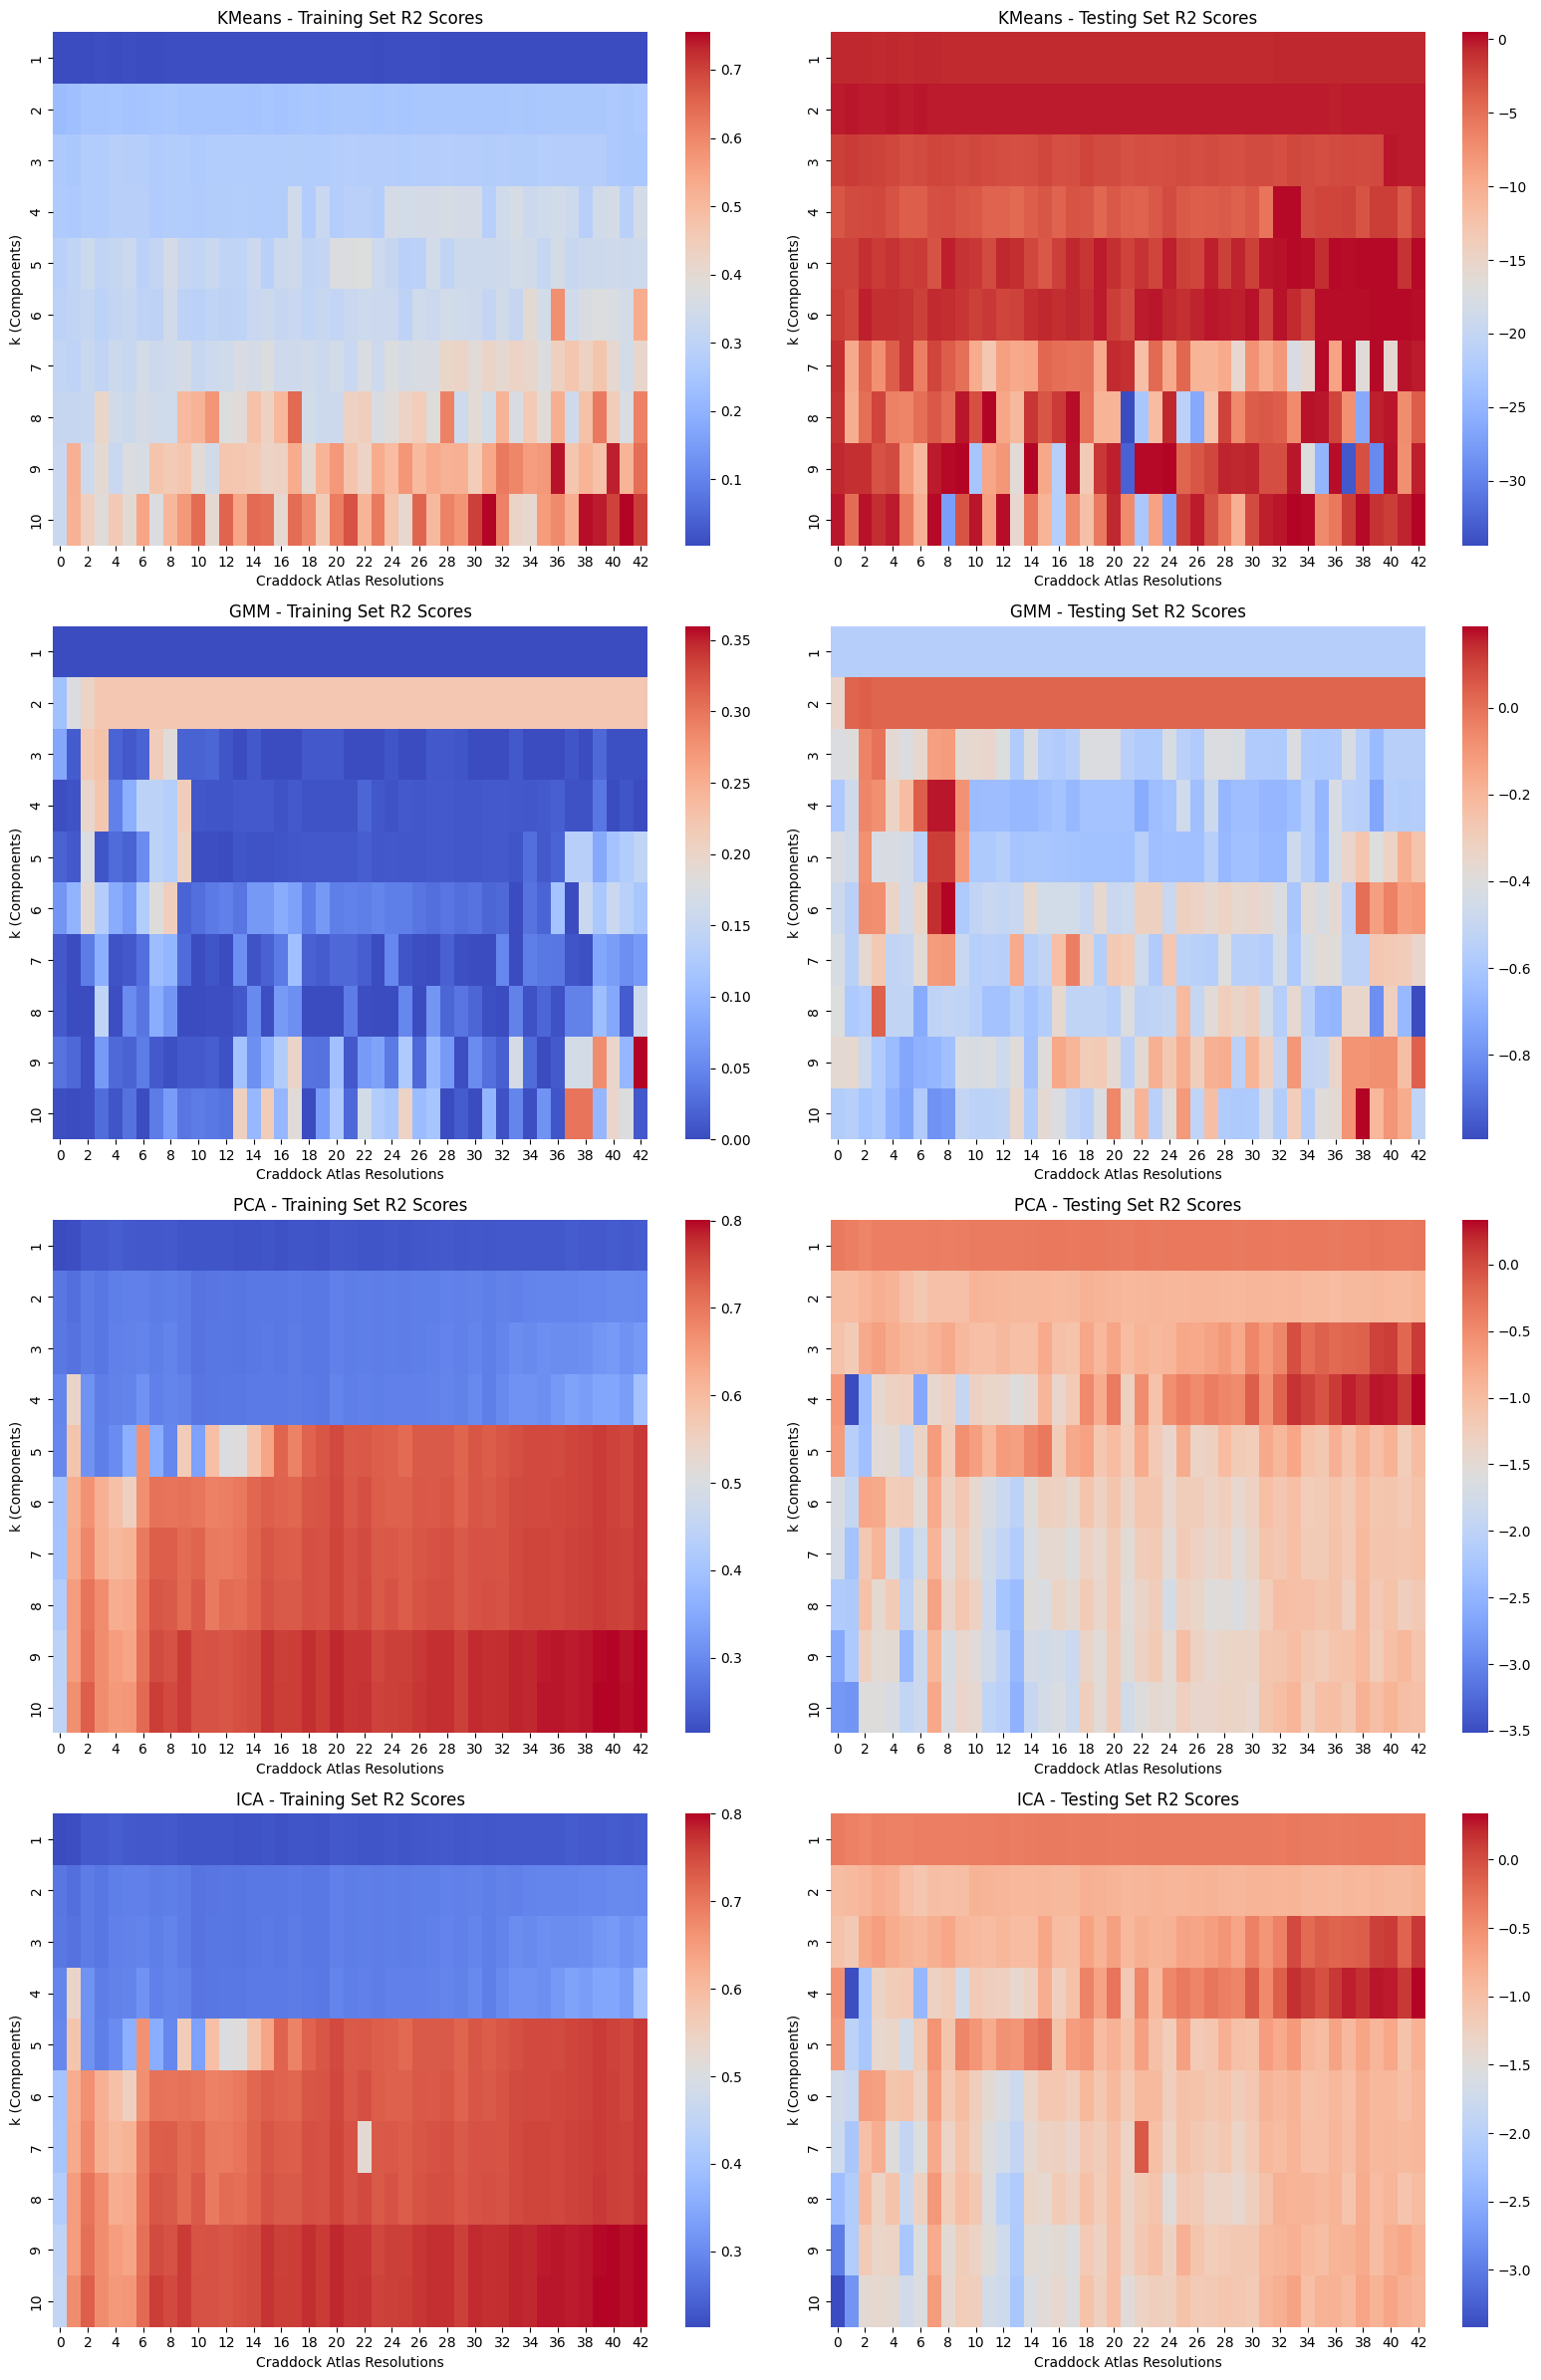

In [106]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100) # Load dataset
crad = datasets.fetch_atlas_craddock_2012()
atlas_indices = list(range(43)) # List of atlas resolutions
k_values = np.arange(1, 11) # k values from 1 to 10
ridge_q8 = Ridge() # Create Ridge model
KF_q8 = KFold(n_splits=5) # Set up KFold cross-validation
methods = ['KMeans', 'GMM', 'PCA', 'ICA'] # List of methods
results_train = {method: np.zeros((len(k_values), len(atlas_indices))) for method in methods}
results_test = {method: np.zeros((len(k_values), len(atlas_indices))) for method in methods}

for i in atlas_indices: # Iterate through each region
    atlas_nii = index_img(crad['scorr_mean'], i) 
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] #  gives subject age on standard units after z-scoring

    for j, k in enumerate(k_values): # Iterate through each k value
        # Set up & fit models on input variables
        X_kmeans = KMeans(n_clusters=k, random_state=42).fit_transform(input_variables)
        X_gmm = GaussianMixture(n_components=k, random_state=42).fit_predict(input_variables).reshape(-1, 1)
        X_pca = PCA(n_components=k, random_state=42).fit_transform(input_variables)
        X_ica = FastICA(n_components=k, random_state=42).fit_transform(input_variables)

        for name, method in zip(methods, [X_kmeans, X_gmm, X_pca, X_ica]): # Iterate through each method
            for train_index, test_index in KF_q8.split(input_variables): # Split data into training and testing sets
                X_train, X_test = method[train_index], method[test_index] # Split training data
                y_train, y_test = output_variable[train_index], output_variable[test_index] # Split testing data

                ridge_q8.fit(X_train, y_train) # Fit Ridge model
                y_pred_train = ridge_q8.predict(X_train) # Predict training data
                y_pred_test = ridge_q8.predict(X_test) # Predict testing data

                results_train[name][j, i] = r2_score(y_train, y_pred_train) # Store training R2 score
                results_test[name][j, i] = r2_score(y_test, y_pred_test) # Store testing R2 score

# Plot the heatmaps
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
for idx, method in enumerate(methods):
    # Plot heatmap
    sns.heatmap(results_train[method], ax=axes[idx, 0], cmap="coolwarm", yticklabels=k_values)
    axes[idx, 0].set_title(f'{method} - Training Set R2 Scores') # Add title
    axes[idx, 0].set_xlabel('Craddock Atlas Resolutions') # Add x-axis label
    axes[idx, 0].set_ylabel('k (Components)') # Add y-axis label
    # Plot second heatmap
    sns.heatmap(results_test[method], ax=axes[idx, 1], cmap="coolwarm", yticklabels=k_values)
    axes[idx, 1].set_title(f'{method} - Testing Set R2 Scores') # Add title
    axes[idx, 1].set_xlabel('Craddock Atlas Resolutions') # Add x-axis label
    axes[idx, 1].set_ylabel('k (Components)') # Add y-axis label
plt.tight_layout()
plt.show()

### **Question 9**

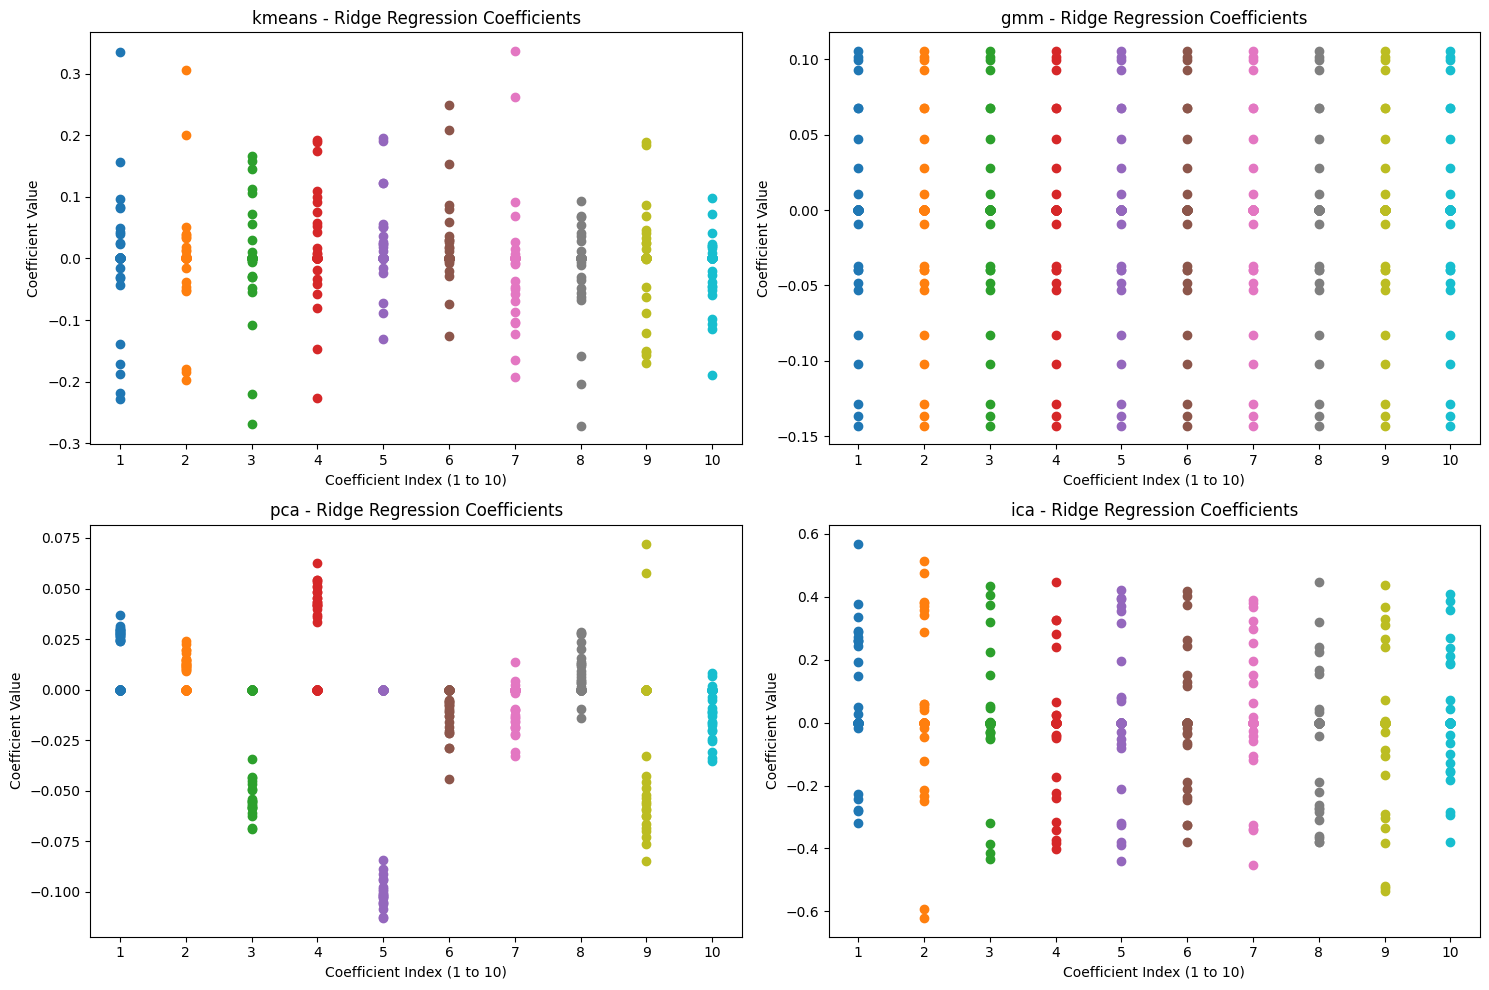

In [110]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100) # Load dataset
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 42) # this needs to be modified for some tasks print('%i regions found in this atlas' % (len(np.unique(atlas_nii.get_data().ravel())) - 1))
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] #  gives subject age on standard units after z-scoring

ridge_q9 = Ridge() # Create Ridge model
k_values = np.arange(1, 11) # Get k values from 1 to 10

# Coefficient matrices for each method (20 KFold)*(5 fold)=100 estimates
kmeans_coefs, gmm_coefs, pca_coefs, ica_coefs = np.zeros((100, 10)), np.zeros((100, 10)), np.zeros((100, 10)), np.zeros((100, 10))
coef_dict = {'kmeans': kmeans_coefs, 'gmm': gmm_coefs, 'pca': pca_coefs, 'ica': ica_coefs}

for i in range(20): # Repeat process 20 times
    random_state_kfold = np.random.randint(0,1000)  # New random state for each iteration
    KF_q9 = KFold(n_splits=5, shuffle=True, random_state=random_state_kfold) # Create KFold object with 5 splits

    for train_index, test_index in KF_q9.split(input_variables): # Split data into training and testing sets
        random_state_method = np.random.randint(0,1000)  # New random state for each method
        # Apply dimensionality reduction & fit model for each method
        X_kmeans = KMeans(n_clusters=10, random_state=random_state_method).fit_transform(input_variables)
        X_gmm = GaussianMixture(n_components=10, random_state=random_state_method).fit_predict(input_variables).reshape(-1, 1)
        X_pca = PCA(n_components=10, random_state=random_state_method).fit_transform(input_variables)
        X_ica = FastICA(n_components=10, random_state=random_state_method).fit_transform(input_variables)
        
        names_dict = {'kmeans': X_kmeans, 'gmm': X_gmm, 'pca': X_pca, 'ica': X_ica} # Store method names
        
        for name, method in names_dict.items(): # Iterate through each method
            X_train, X_test = method[train_index], method[test_index] # Split training data
            y_train, y_test = output_variable[train_index], output_variable[test_index] # Split testing data
            ridge_q9.fit(X_train, y_train) # Fit Ridge model
            coef_dict[name][i,:] = ridge_q9.coef_.flatten() # Store coefficients

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for idx, method in enumerate(['kmeans', 'gmm', 'pca', 'ica']): # Iterate over each method
    coeffs = coef_dict[method]  # Coefficients matrix for current method (100x10)
    for i in range(10):  # For each of 10 coefs, plot 100 estimates
        axes[idx].scatter(np.full(100, i + 1), coeffs[:, i], label=f'Coeff {i+1}' if i == 0 else "")
    axes[idx].set_title(f'{method} - Ridge Regression Coefficients') # Add title
    axes[idx].set_xlabel('Coefficient Index (1 to 10)') # Add x-axis label
    axes[idx].set_ylabel('Coefficient Value') # Add y-axis label
    axes[idx].set_xticks(np.arange(1, 11))  # Set x-axis ticks
plt.tight_layout()
plt.show()

### **Question 10**

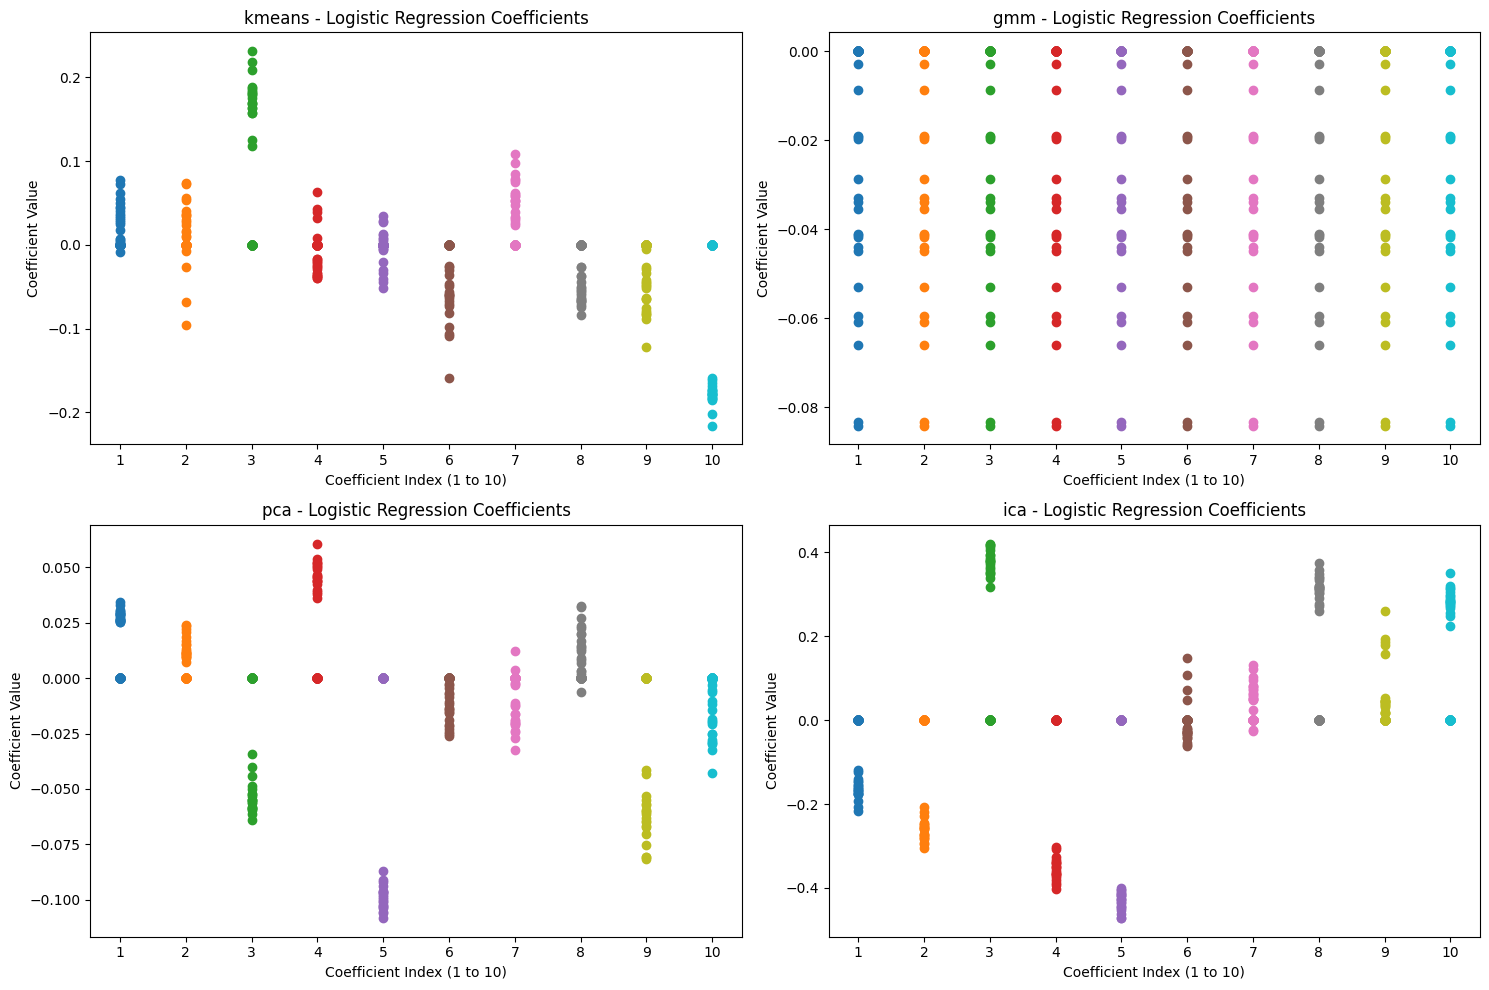

In [109]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100) # Load dataset
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 42) 
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] #  gives subject age on standard units after z-scoring

ridge_q10 = Ridge() # Create Ridge model
k_values = np.arange(1, 11) # Get k values from 1 to 10

# Coefficient matrices for each method (20 KFold)*(5 fold)=100 estimates
kmeans_coefs, gmm_coefs, pca_coefs, ica_coefs = np.zeros((100, 10)), np.zeros((100, 10)), np.zeros((100, 10)), np.zeros((100, 10))
coef_dict = {'kmeans': kmeans_coefs, 'gmm': gmm_coefs, 'pca': pca_coefs, 'ica': ica_coefs}

for i in range(20): # Repeat process 20 times
    random_state_kfold = np.random.randint(0,1000)  # New random state for each iteration
    KF_q10 = KFold(n_splits=5, shuffle=True, random_state=random_state_kfold) # Create Kfold object with 5 splits
    # Create the 4 methods and fit on input variables
    X_kmeans = KMeans(n_clusters=10, random_state=42).fit_transform(input_variables)
    X_gmm = GaussianMixture(n_components=10, random_state=42).fit_predict(input_variables).reshape(-1, 1)
    X_pca = PCA(n_components=10, random_state=42).fit_transform(input_variables)
    X_ica = FastICA(n_components=10, random_state=42).fit_transform(input_variables)
    
    for train_index, test_index in KF_q10.split(input_variables): # Split data
        names_dict = {'kmeans': X_kmeans, 'gmm': X_gmm, 'pca': X_pca, 'ica': X_ica} # Store method names
        
        for name, method in names_dict.items(): # Iterate through each method
            X_train, X_test = method[train_index], method[test_index] # Split training data
            y_train, y_test = output_variable[train_index], output_variable[test_index] # Split testing data

            ridge_q10.fit(X_train, y_train) # Fit Ridge model
            coef_dict[name][i,:] = ridge_q10.coef_.flatten() # Store coefficients

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for idx, method in enumerate(['kmeans', 'gmm', 'pca', 'ica']): # Iterate over each method
    coeffs = coef_dict[method]  # Coefficients matrix for current method (100x10)
    for i in range(10):  # For each of 10 coefs, plot 100 estimates
        axes[idx].scatter(np.full(100, i + 1), coeffs[:, i], label=f'Coeff {i+1}' if i == 0 else "")
    axes[idx].set_title(f'{method} - Logistic Regression Coefficients') # Add title
    axes[idx].set_xlabel('Coefficient Index (1 to 10)') # Add x-axis label
    axes[idx].set_ylabel('Coefficient Value') # Add y-axis label
    axes[idx].set_xticks(np.arange(1, 11))  # Set x-axis to show 1 to 10 for the 10 coefficients
plt.tight_layout()
plt.show()